Описание алгоритмов и примеры работы
========================

Подготовительный этап
------------------------

Для начала необходимо установить библиотеки из списка библиотек

In [ ]:
!pip install -r requirements.txt

Подключим все необходимые зависимости

In [1]:
import cv2
import numpy as np
import json
import os
from sklearn.cluster import KMeans
from shapely import geometry, ops
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from intelligent_placer_lib import utils

Выберем файл на котором будет производиться проверка

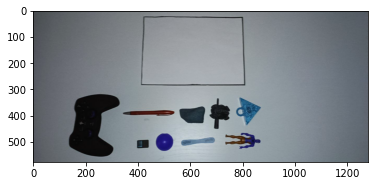

In [2]:
image_path = "test_cases/1.jpg"
image_to_check  = cv2.imread(image_path)
imshow(image_to_check)

Выделение контура многоугольника
------------------------

### Шаг 1) Выделение границ фильтром Canny

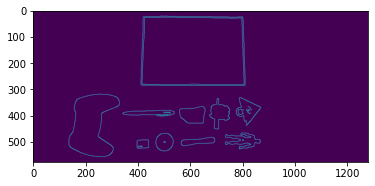

In [3]:
img_gray = cv2.cvtColor(image_to_check, cv2.COLOR_BGR2GRAY)
img_gauss = cv2.GaussianBlur(img_gray, (5, 5), 0)
img_canny = cv2.Canny(img_gauss, 100, 200)
imshow(np.asarray(img_canny))

### Шаг 2) Выделение контуров при помощи OpenCV

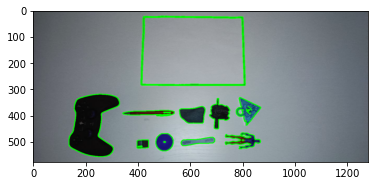

In [4]:
# find countours on binary thresholded canny
contours, hierarchy = cv2.findContours(image=img_canny, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

### Шаг 3) Выкинуть контуры, у которых малое число вложенных контуров

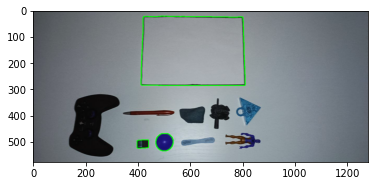

In [5]:
# get amount of nested childs
childs_number = [[0] * 2 for t in range(len(contours))]
for i in range(len(contours)):
    start = i
    childs_number[i][0] = i
    while hierarchy[0][start][2] != -1:
        childs_number[i][1] += 1
        start = hierarchy[0][start][2]

childs_number.sort(key=lambda x : -x[1])

good_contours = []

# get all contours with amount of childs are greater than 2
for i in range(len(childs_number)):
    if childs_number[i][1] >= 2:
        good_contours.append(childs_number[i][0])
        
image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=[contours[i] for i in good_contours], contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

### Шаг 4) Выкинуть контуры, у которых интенсивность внутри слишком низкая (не тот фон), а на краю слишком высокая(не тот контур)

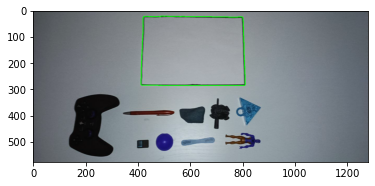

In [6]:
BG_INTENCITY = 120
BORDER_INTENCITY = 100

chosen_contour = -1

# final decision is based on inner color and border color
for contour_index in good_contours:
    saved_contour_index = contour_index
    
    #calculate inner point
    M = cv2.moments(contours[contour_index])
    inner_point = [int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])]

    #detect point on border of this contour
    cnt = 1
    border_point = contours[contour_index][0][0]
    while hierarchy[0][contour_index][2] != -1:
        contour_index = hierarchy[0][contour_index][2]
        border_point[0] += contours[contour_index][0][0][0]
        border_point[1] += contours[contour_index][0][0][1]
        cnt += 1
    border_point[0] /= cnt
    border_point[1] /= cnt

    # check border color
    border_color = tuple([float(t) for t in image_to_check[border_point[1]][border_point[0]]])
    
    # if border point is too bright
    if border_color[0] >= BORDER_INTENCITY or border_color[1] >= BORDER_INTENCITY or border_color[2] >= BORDER_INTENCITY:
        continue

    inner_color = tuple([float(t) for t in image_to_check[inner_point[1]][inner_point[0]]])

    # if background point is too dark
    if inner_color[0] <= BG_INTENCITY or inner_color[1] <= BG_INTENCITY  or inner_color[2] <= BG_INTENCITY:
        continue

    chosen_contour = saved_contour_index
    
result = contours[chosen_contour]

contour_to_check = result

image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=[result], contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

### Замечания

Помимо описанного выше алгоритма, так-же производится проверка на выпуклость. Заключается она в построении выпуклой оболочки и сравнению площадей по формуле

$$ \frac{|S_{convexHull} - S_{contour}|}{max(S_{convexHull}, S_{contour})} $$

Если значение меньше чем 0.05 то контур считается выпуклым

Выделение контуров объектов
------------------------

### Шаг 1) Нормализация изображения

Нормализация необходима для удаления шумов с изображения и работы с неравномерным освещением

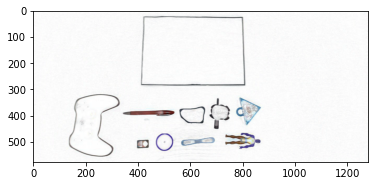

In [7]:
rgb_planes = cv2.split(image_to_check)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_norm_planes.append(norm_img)

image_norm = cv2.merge(result_norm_planes)
imshow(image_norm)

### Шаг 2) Бинаризация изображения

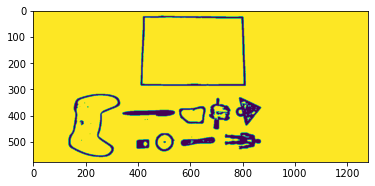

In [8]:
img_gray = cv2.cvtColor(image_norm, cv2.COLOR_BGR2GRAY)
img_gauss = cv2.GaussianBlur(img_gray, (5, 5), 0)

#threshold image
res, img_threshold = cv2.threshold(img_gauss, 230, 255, cv2.THRESH_BINARY)
imshow(img_threshold)

### Шаг 3) Выделение контуров при помощи OpenCV

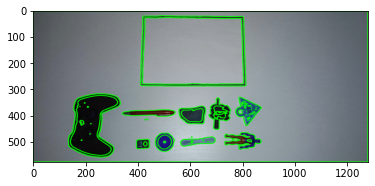

In [9]:
# find countours on binary thresholded image
contours, hierarchy = cv2.findContours(image=img_threshold, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

### Шаг 4) Фильтрация контуров и построение выпуклых оболочек

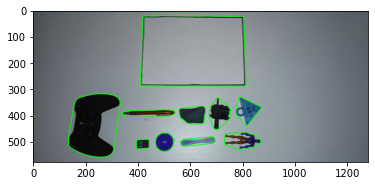

In [10]:
convex_contours = []
for i in range(len(contours)):
    if (cv2.contourArea(contours[i]) <= 0.5 * img_threshold.shape[0] * img_threshold.shape[1] and
        cv2.contourArea(contours[i]) >= 0.002 * img_threshold.shape[0] * img_threshold.shape[1] and
        hierarchy[0][hierarchy[0][i][3]][3] == -1):
        convex_contours.append(cv2.convexHull(contours[i]))
        
image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=convex_contours, contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

### Шаг 5) Фильтрация контуров объектов если они пересекаются с контуром многоугольника

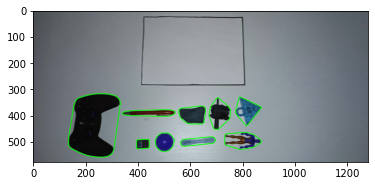

In [11]:
objects_to_check = [obj for obj in convex_contours if utils.contours_intersect_area(obj, contour_to_check) == 0]

image_copy = image_to_check.copy()
cv2.drawContours(image=image_copy, contours=objects_to_check, contourIdx=-1, color=(0, 255, 0), thickness=2,
                     lineType=cv2.LINE_AA)
imshow(image_copy)

Алгоритм укладки
------------------------

### Шаг 1) Проверка укладки каждого объекта

Используется минимация функции 

$f1(x, y, \theta) = dist(object(x, y, \theta), contour)^2 + area(substract(object(x, y, \theta), contour))$
Где

$x$ - перемещение по оси X

$y$ - перемещение по оси Y

$\theta$ - поворот

$object(x, y, \theta)$ - множество точек объекта, после переноса и поворота

$contour$ - множество точек контура

$dist(A,B)$ - расстояние между двумя множествами A и B

$area(A)$ - площадь множества A

$substract(A, B)$ - разность множеств A и B

In [12]:
def one_object_optimize_function(data, object, contour):
    posx, posy, rot = data

    #move object by parameter
    object_tmp = utils.rotate_contour(object, rot)
    object_tmp = object_tmp + [posx, posy]

    # First - we have distance between object and contour
    res = utils.contours_distance(object_tmp, contour) ** 2
    res = res

    # Second - we have area of object minus area of intersection between object and contour
    polygon1 = [(el[0][0], el[0][1]) for el in object_tmp]
    polygon2 = [(el[0][0], el[0][1]) for el in contour]
    polygon1 = geometry.Polygon(polygon1)
    polygon2 = geometry.Polygon(polygon2)

    res += max((polygon1 - polygon2).area, 0)
    return max(res, 0)

C:\Users\Sairsey\AppData\Local\Temp\ipykernel_10580\2163953597.py:4: OptimizeWarning: Unknown solver options: gtol
  res = minimize(one_object_optimize_function, (0.1, 0.1, 0.1) , args=(obj, contour_to_check), options={'gtol': 1e-7}, method="Nelder-Mead")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats o

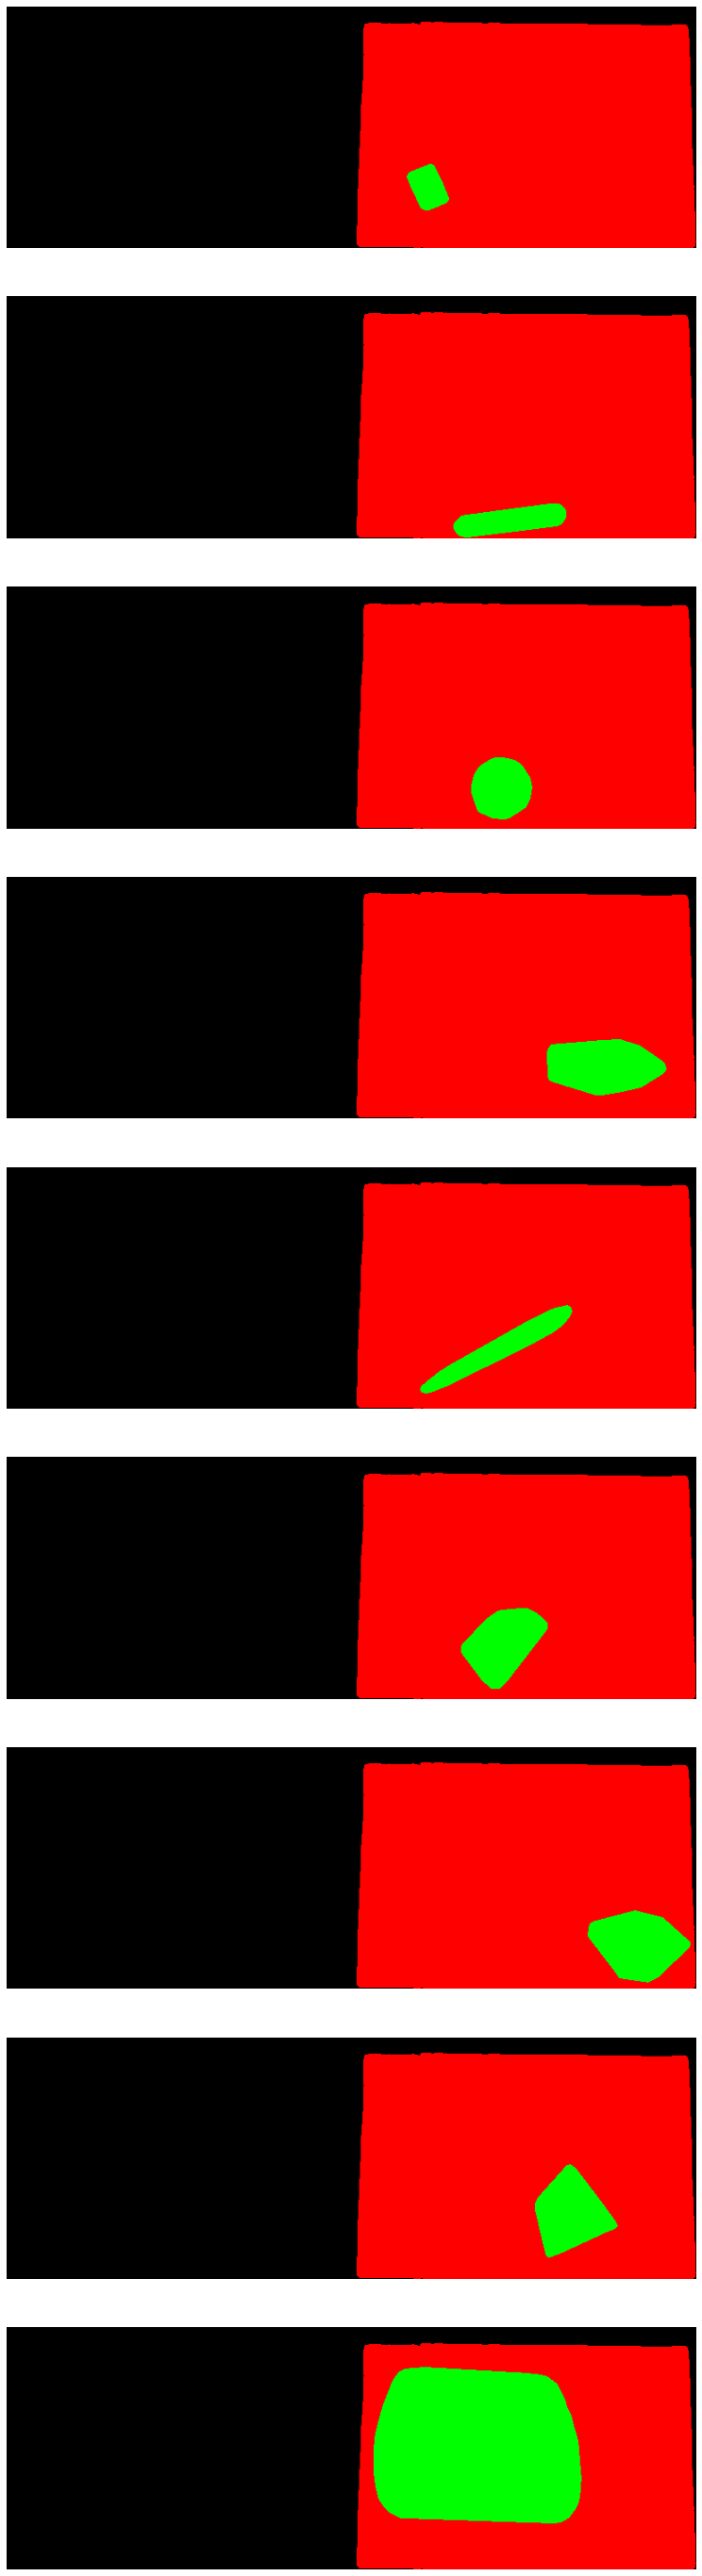

In [13]:
fig, ax = plt.subplots(len(objects_to_check), 1, figsize=(50, 50))

for index, obj in enumerate(objects_to_check):    
    res = minimize(one_object_optimize_function, (0.1, 0.1, 0.1) , args=(obj, contour_to_check), options={'gtol': 1e-7}, method="Nelder-Mead")
    res = res.x
    new_contour = utils.rotate_contour(obj, res[2]).astype(np.int32)
    new_contour += [int(res[0]), int(res[1])]

    # Create image filled with zeros the same size of original image
    x1, y1, w1, h1 = cv2.boundingRect(contour_to_check)
    x2, y2, w2, h2 = cv2.boundingRect(new_contour)
    w1 += x1
    h1 += y1
    w2 += x2
    h2 += y2
    blank = np.zeros((max(h1, h2), max(w1, w2), 3))

    blank = cv2.fillPoly(blank, [contour_to_check], (255, 0, 0))
    blank = cv2.fillPoly(blank, [new_contour], (0, 255, 0))
    
    ax[index].set_axis_off()
    ax[index].imshow(blank)

### Шаг 2) Проверка укладки всех объектов

Используется минимация функции 


$$f2(x_1, y_1, \theta_1, x_2, y_2, ...) = \sum_{i=1}^m f1(x_i, y_i, \theta_i) +  \sum_{i,j=1}^m area(intersect(object_i(x_i, y_i, \theta_i), object_j(x_j, y_j, \theta_j)))$$


In [14]:
def many_object_optimize_function(data, objects, contour):
    res = 0
    # each object must be inside
    for i in range(len(objects)):
        res += one_object_optimize_function((data[3 * i + 0], data[3 * i + 1], data[3 * i + 2]), objects[i], contour)
    # and they must not overlap
    for i in range(len(objects)):
        posx1, posy1, rot1 = data[3 * i + 0], data[3 * i + 1], data[3 * i + 2]
        first_object = utils.rotate_contour(objects[i], rot1)
        first_object += [posx1, posy1]
        polygon1 = [(el[0][0], el[0][1]) for el in first_object]
        polygon1 = geometry.Polygon(polygon1)
        for j in range(i + 1, len(objects)):
            posx2, posy2, rot2 = data[3 * j + 0], data[3 * j + 1], data[3 * j + 2]
            second_object = utils.rotate_contour(objects[j], rot2)
            second_object += [posx2, posy2]
            polygon2 = [(el[0][0], el[0][1]) for el in second_object]
            polygon2 = geometry.Polygon(polygon2)

            res += polygon1.intersection(polygon2).area

    return res

205779.32349274124
124794.20182987451
87403.5303219399
63294.2621046169
38064.83339180655
33294.045309074194
26139.747009620107
23283.23653987086
20143.502627937436
18853.652404333247
16401.471836610002
14682.995500726885
13064.295760845698
11046.65605265829
9649.843843427181
8339.88474452816
6242.203506485482
5076.751293736165
3723.2776843362376
2870.973935263409
2113.1803015443647
1588.4692317248691
1377.3855645904273
1004.2778002876732
858.9937250278946
625.8834051144355
573.4121146377454
478.18808835148724
355.8225608640696
277.55630014248567
252.62279671136423
217.49188128097006
182.4379768137822
150.52697714546065
145.4285024247618
135.9881528618057
118.59564321143074
112.6496488052933
103.64844707426735
93.41468996662263
77.38945607370036
71.0367628855171
61.11124456916187
48.61253012743122
40.84278542944158
32.181661181379674
19.75787153197248
9.92135783964033
2.704108701832757
0.8360974300667336
0.625476558145423
0.3469068940925562
0.3302148477862852
0.19161535447652311
0.0616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0


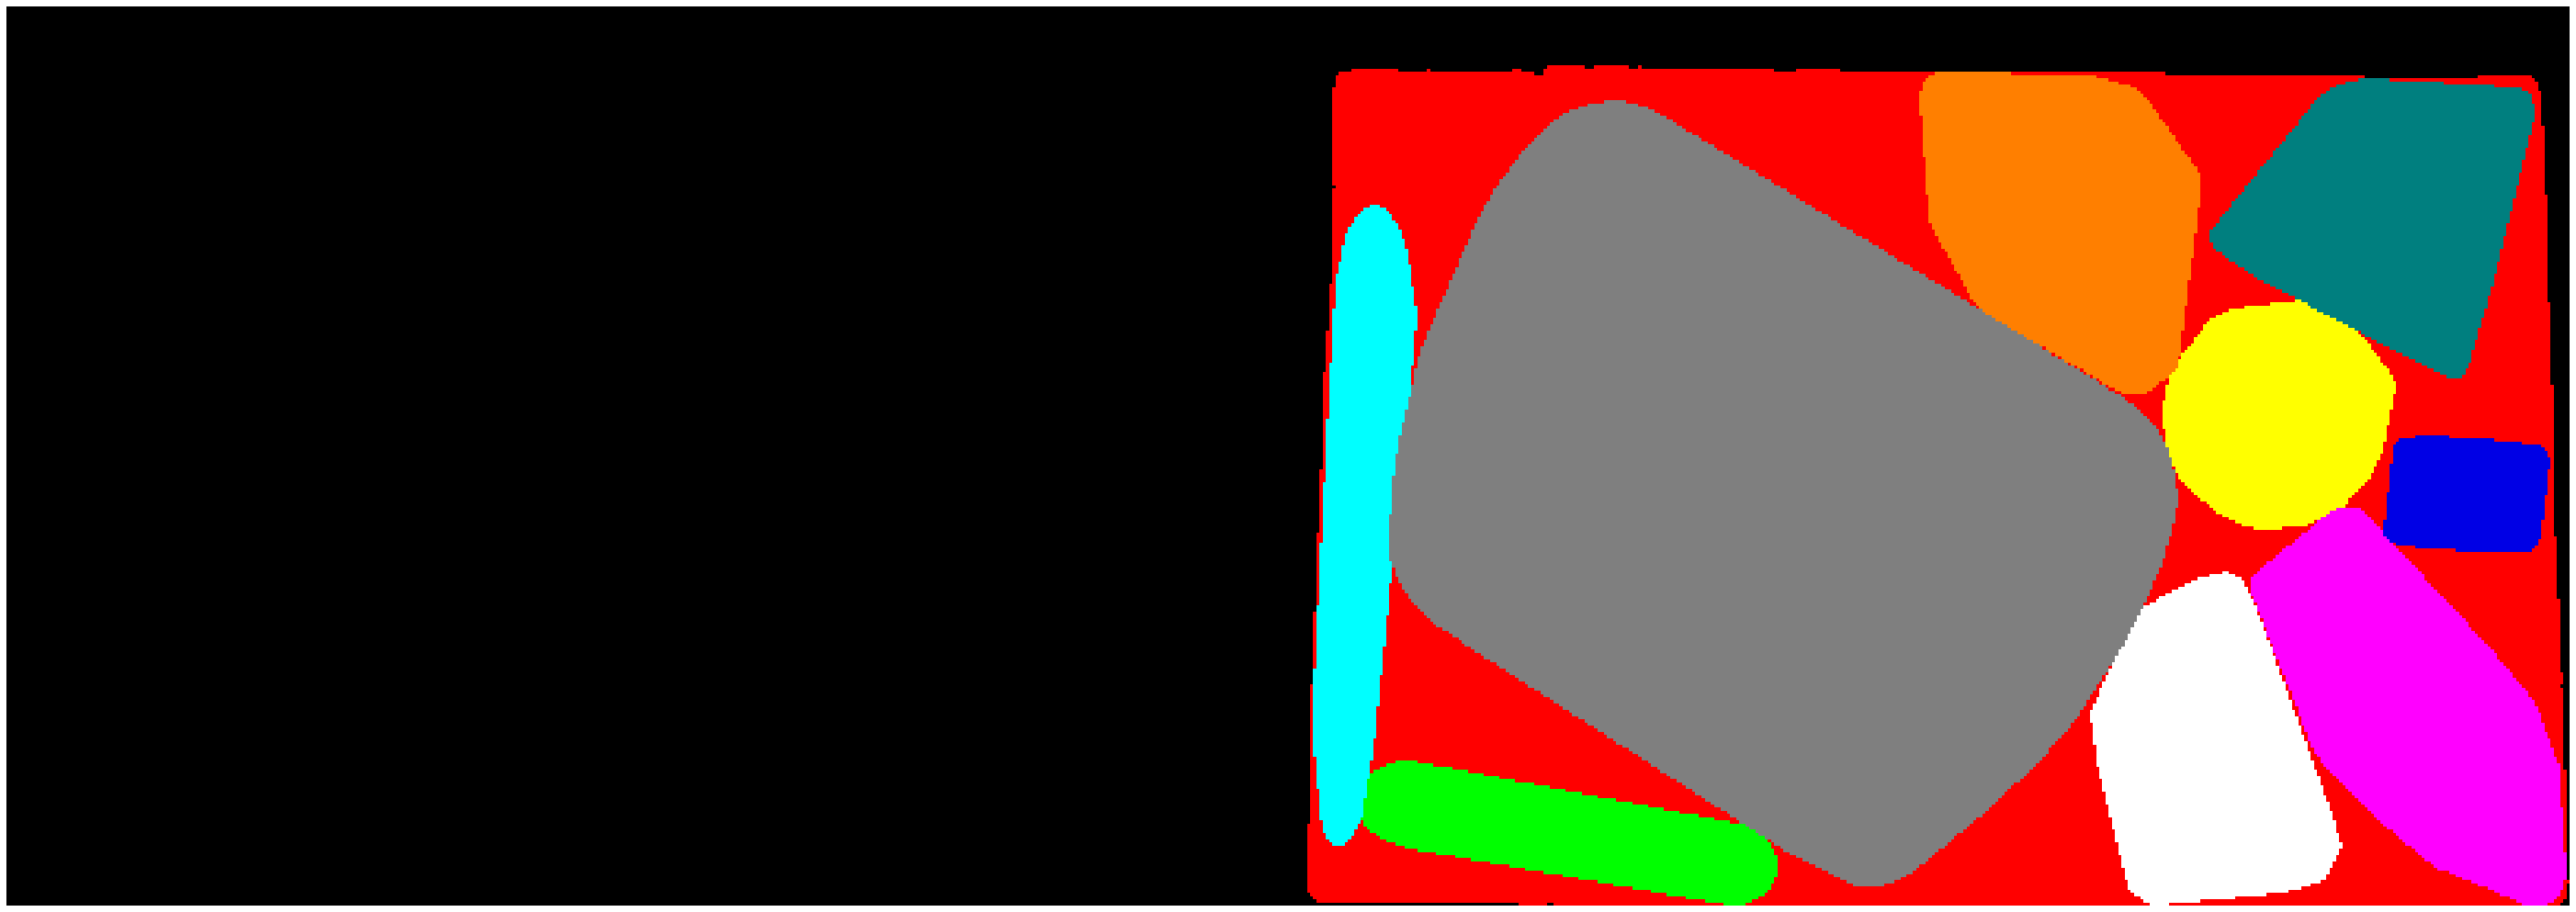

In [15]:
initial_guess = []
for o in objects_to_check:
    initial_guess.append(0.1) # position
    initial_guess.append(0.1) # position
    initial_guess.append(0.1) # rotation
    
def callbk(x):
    print(many_object_optimize_function(x, objects_to_check, contour_to_check))
    
res = minimize(many_object_optimize_function, 
               initial_guess, 
               args=(objects_to_check, contour_to_check), 
               options={'gtol': 1e-7},
               callback=callbk)
res = res.x
x1, y1, w1, h1 = cv2.boundingRect(contour_to_check)
w1 += x1
h1 += y1

for i in range(len(objects_to_check)):
    obj = objects_to_check[i]
    new_contour = utils.rotate_contour(obj, res[3 * i + 2]).astype(np.int32)
    new_contour += [int(res[3 * i + 0]), int(res[3 * i + 1])]

    # Create image filled with zeros the same size of original image
    x2, y2, w2, h2 = cv2.boundingRect(new_contour)
    w2 += x2
    h2 += y2
            
    h1 = max(h1, h2)
    w1 = max(w1, w2)
    
blank = np.zeros((h1, w1, 3))
blank = cv2.fillPoly(blank, [contour_to_check], (255, 0, 0))
colors = [
    [0, 0, 0.9],
    [0, 1, 0],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1],
    [1, 0.5, 0],
    [0, 0.5, 0.5],
    [0.5, 0.5, 0.5],
    [0.1, 0.5, 0.9]]
for i in range(len(objects_to_check)):
    obj = objects_to_check[i]
    new_contour = utils.rotate_contour(obj, res[3 * i + 2]).astype(np.int32)
    new_contour += [int(res[3 * i + 0]), int(res[3 * i + 1])]
    blank = cv2.fillPoly(blank, [new_contour], colors[i])

fig, ax = plt.subplots(1, 1, figsize=(50, 50))

ax.imshow(blank)
ax.set_axis_off()